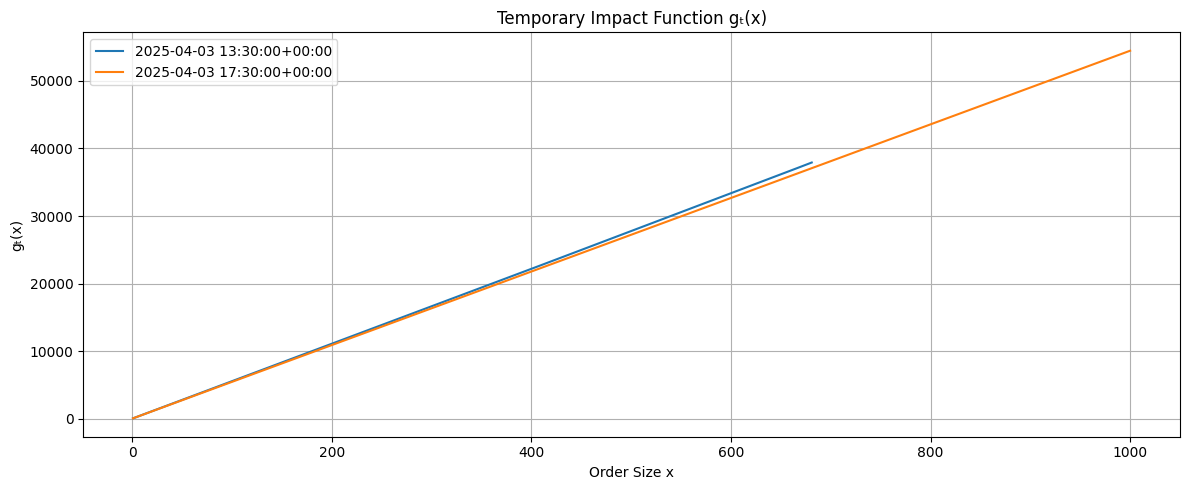

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data file
df = pd.read_csv("Data/CRWV/CRWV_2025-04-03 00:00:00+00:00.csv")
df['ts_event'] = pd.to_datetime(df['ts_event'], utc=True, format='ISO8601')
df = df.sort_values("ts_event")
df['minute'] = df['ts_event'].dt.floor('min')

# Extract snapshots for two specific minutes
target_minutes = [
    pd.Timestamp("2025-04-03 13:30:00+00:00"),
    pd.Timestamp("2025-04-03 17:30:00+00:00")
]
snapshots = df[df['minute'].isin(target_minutes)].groupby('minute').head(1)

def compute_gt(row):
    ask_prices = np.array([row[f'ask_px_0{i}'] for i in range(10)])
    ask_sizes = np.array([row[f'ask_sz_0{i}'] for i in range(10)])
    mask = ~np.isnan(ask_prices) & ~np.isnan(ask_sizes)
    ask_prices = ask_prices[mask]
    ask_sizes = ask_sizes[mask]
    if len(ask_prices) == 0:
        return None, None
    cum_qty = np.cumsum(ask_sizes)
    cum_cost = np.cumsum(ask_prices * ask_sizes)

    def g_t(x):
        if x > cum_qty[-1]: return np.nan
        idx = np.searchsorted(cum_qty, x)
        if idx == 0: return x * ask_prices[0]
        prev_qty = cum_qty[idx - 1]
        prev_cost = cum_cost[idx - 1]
        return prev_cost + (x - prev_qty) * ask_prices[idx]

    x_vals = np.arange(1, 1001)
    g_vals = [g_t(x) for x in x_vals]
    return x_vals, g_vals

# Plot
plt.figure(figsize=(12, 5))
for _, row in snapshots.iterrows():
    x_vals, g_vals = compute_gt(row)
    if x_vals is not None:
        plt.plot(x_vals, g_vals, label=f"{row['minute']}")

plt.title("Temporary Impact Function gₜ(x)")
plt.xlabel("Order Size x")
plt.ylabel("gₜ(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
